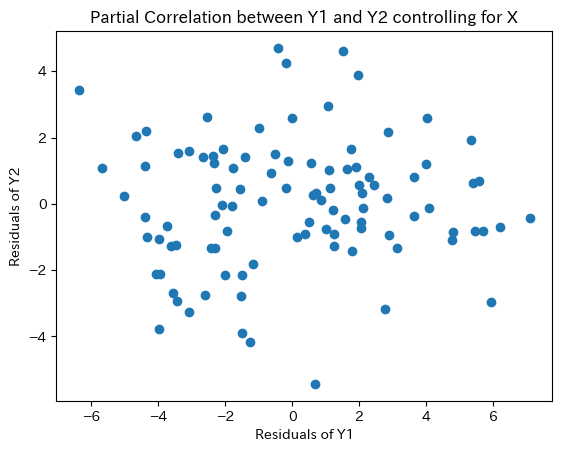

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


# 仮想データの生成（実際には実データを使用）
np.random.seed(0)
X = np.random.randn(100) * 1.5 - 3
Y1 = -1.7 * X + np.random.randn(100) * 3 + 4
Y2 = 0.23 * X + np.random.randn(100) * 2 + 1

# Zに基づいてXの線形回帰モデルを構築
model_Y1 = LinearRegression().fit(X.reshape(-1, 1), Y1)
# Xの予測値を計算し、残差を求める
predicted_Y1 = model_Y1.predict(X.reshape(-1, 1))
residuals_Y1 = Y1 - predicted_Y1

# Zに基づいてYの線形回帰モデルを構築
model_Y2 = LinearRegression().fit(X.reshape(-1, 1), Y2)
# Yの予測値を計算し、残差を求める
predicted_Y2 = model_Y2.predict(X.reshape(-1, 1))
residuals_Y2 = Y2 - predicted_Y2

# 残差を用いてXとYの関係を視覚化
plt.scatter(residuals_Y1, residuals_Y2)
plt.xlabel("Residuals of Y1")
plt.ylabel("Residuals of Y2")
plt.title("Partial Correlation between Y1 and Y2 controlling for X")
plt.show()

In [118]:
model_Y1.coef_

array([-1.47060313])

In [119]:
model_Y2.coef_

array([0.32586118])

In [75]:
np.corrcoef(residuals_Y1, residuals_Y2)

array([[1.        , 0.04796907],
       [0.04796907, 1.        ]])

In [78]:
import pandas as pd


df = pd.DataFrame({"X": X, "Y1": Y1, "Y2": Y2})
df.head(3)

,X,Y1,Y2
0,-0.353921,10.251119,0.180234
1,-2.399764,4.036322,-0.030704
2,-1.531893,2.792763,2.846984


In [79]:
import pingouin as pg

In [80]:
pg.pcorr(df)

,X,Y1,Y2
X,1.000000,-0.579214,0.232300
Y1,-0.579214,1.000000,0.047969
Y2,0.232300,0.047969,1.000000


In [81]:
def P(X: np.ndarray):
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    return X.dot(np.linalg.inv(X.T.dot(X))).dot(X.T)


def Q(X: np.ndarray):
    return np.eye(X.shape[0]) - P(X)

In [92]:
# Y1, Y2 | X
crr = np.corrcoef(
    Q(X - X.mean(axis=0)).dot(Y1 - Y1.mean(axis=0)),
    Q(X - X.mean(axis=0)).dot(Y2 - Y2.mean(axis=0)),
)
assert np.allclose(crr[0, 1], pg.pcorr(df)["Y1"]["Y2"])
crr

array([[1.        , 0.04796907],
       [0.04796907, 1.        ]])

True

In [93]:
# X, Y2 | Y1
crr = np.corrcoef(
    Q(Y1 - Y1.mean(axis=0)).dot(X - X.mean(axis=0)),
    Q(Y1 - Y1.mean(axis=0)).dot(Y2 - Y2.mean(axis=0)),
)
assert np.allclose(crr[0, 1], pg.pcorr(df)["X"]["Y2"])
crr

array([[1.        , 0.23230038],
       [0.23230038, 1.        ]])

In [94]:
# X, Y1 | Y2
crr = np.corrcoef(
    Q(Y2 - Y2.mean(axis=0)).dot(X - X.mean(axis=0)),
    Q(Y2 - Y2.mean(axis=0)).dot(Y1 - Y1.mean(axis=0)),
)
assert np.allclose(crr[0, 1], pg.pcorr(df)["X"]["Y1"])
crr

array([[ 1.        , -0.57921412],
       [-0.57921412,  1.        ]])

In [47]:
np.linalg.det(Q(Y1)).round(1)

0.0

# 残差と射影の関係

In [95]:
residuals_Y1[:5]

array([ 4.81699071, -4.40642865, -4.37369339,  1.91165005, -4.3874474 ])

In [99]:
# Q_x Y1 = (I-P_x)Y1 = X - P_z X
Q(X - X.mean(axis=0)).dot(Y1 - Y1.mean(axis=0))[:5]

array([ 4.81699071, -4.40642865, -4.37369339,  1.91165005, -4.3874474 ])

In [100]:
assert np.allclose(residuals_Y1, Q(X - X.mean(axis=0)).dot(Y1 - Y1.mean(axis=0)))

In [102]:
# Q_x Y1 = (I-P_x)Y1 = Y1 - P_x Y1
Q(X).dot(Y1)[:5]

array([ 9.26007398, -2.68345503, -1.49681643,  7.30572974,  0.26206427])

# 重回帰モデルと射影の関係

In [103]:
predicted_Y1[:5]

array([5.4341279 , 8.44275059, 7.16645654, 4.38226242, 5.20580431])

In [104]:
P(X - X.mean()).dot(Y1 - Y1.mean())[:5]

array([-3.75940058, -0.75077788, -2.02707194, -4.81126606, -3.98772416])

In [105]:
# X_hat = aZ + b
P(X - X.mean()).dot(Y1)[:5]

array([-3.75940058, -0.75077788, -2.02707194, -4.81126606, -3.98772416])

In [106]:
Q(X).dot(Y1)[:5]

array([ 9.26007398, -2.68345503, -1.49681643,  7.30572974,  0.26206427])

In [108]:
np.allclose(P(X).dot(Y1) + Q(X).dot(Y1), Y1)

True

In [107]:
np.allclose(
    P(X - X.mean()).dot(Y1 - Y1.mean()) + Q(X - X.mean()).dot(Y1 - Y1.mean()),
    Y1 - Y1.mean(),
)

True

<Axes: >

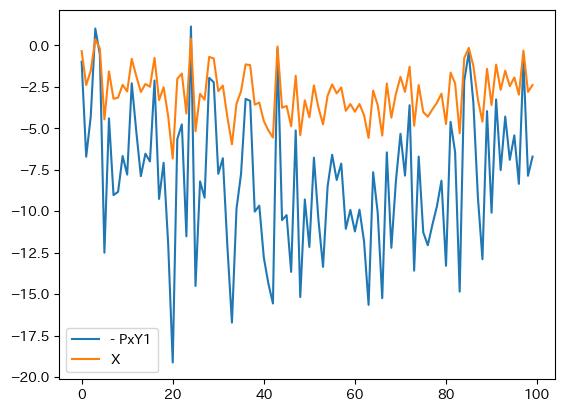

In [109]:
pd.DataFrame({"- PxY1": -P(X).dot(Y1), "X": X}).plot()

In [110]:
pg.corr(-P(X).dot(Y1), X)

,n,r,CI95%,p-val,BF10,power
pearson,100,1.0,"[1.0, 1.0]",0.0,inf,1.0


In [25]:
# a = PzX / Z
(P(Y2).dot(Y1) / Y2).mean()

-1.0864214359652962

<Axes: >

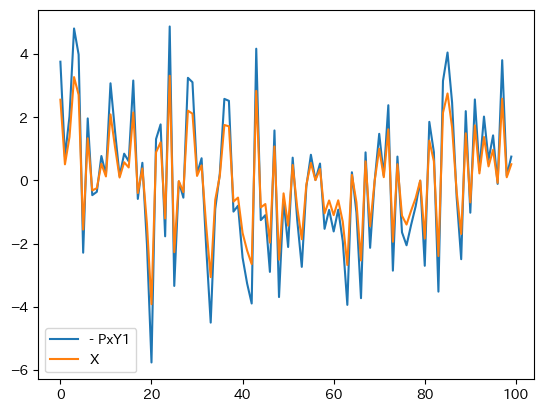

In [113]:
pd.DataFrame(
    {
        "- PxY1": -P(X - X.mean(axis=0)).dot(Y1 - Y1.mean(axis=0)),
        "X": X - X.mean(axis=0),
    }
).plot()

In [114]:
(P(X - X.mean(axis=0)).dot(Y1 - Y1.mean(axis=0)) / (X - X.mean(axis=0))).mean()

-1.4706031329072373

---

$$
\begin{align}
P_{X - \bar{X}} (y - \bar{y}) / (X - \bar{X}) &= a \\
\end{align}
$$

In [124]:
assert np.allclose(
    (P(X - X.mean(axis=0)).dot(Y1 - Y1.mean(axis=0)) / (X - X.mean(axis=0))).mean(),
    model_Y1.coef_[0],
)

---

$$
\begin{align}
y &= P y' + \bar{y} + Q y' \\
\end{align}
$$

In [130]:
# PzX + QzX = X
assert np.allclose(
    P(X - X.mean()).dot(Y1 - Y1.mean())
    + Y1.mean()
    + Q(X - X.mean()).dot(Y1 - Y1.mean()),
    Y1,
)

---

$$
\begin{align}
Q y' &= e_y \\
\end{align}
$$

In [131]:
assert np.allclose(Q(X - X.mean()).dot(Y1 - Y1.mean()), residuals_Y1)

In [132]:
assert np.allclose(predicted_Y1 + residuals_Y1, Y1)

In [135]:
_X = X.reshape(-1, 1)
X_ = _X - _X.mean(axis=0)
_Y1 = Y1.reshape(-1, 1)
Y1_ = _Y1 - _Y1.mean(axis=0)

---

$$
\begin{align}
a &:= (X'^{\mathsf{T}} X')^{-1} X'^{\mathsf{T}} y \\
b &:= \bar{y} - \bar{X} a
\end{align}
$$

In [136]:
a = np.linalg.inv(X_.T.dot(X_)).dot(X_.T).dot(Y1_)
b = _Y1.mean(axis=0) - _X.mean(axis=0).dot(a)
Y1_hat = (_X.dot(a) + b).ravel()

assert np.allclose(Y1_hat, predicted_Y1)

---

$$
\begin{align}
\hat{y} = P y + \bar{y}
\end{align}
$$

---
(proof)

$$
\begin{align}
\hat{y}
    &= X a + b \\
    &= X a + \bar{y} - \bar{X} a \\
    &= X a - \bar{X} a + \bar{y} \\
    &= (X - \bar{X}) a + \bar{y} \\
    &= X' a + \bar{y} \\
    &= P y' + \bar{y} \\
\end{align}
$$



In [33]:
assert np.allclose((P(X_).dot(Y1_) + Y1.mean(axis=0)).ravel(), predicted_Y1)

$$
\begin{align}
y - \hat{y} = Q y'
\end{align}
$$

In [42]:
np.allclose(Q(X_).dot(Y1_).ravel(), residuals_Y1)

True

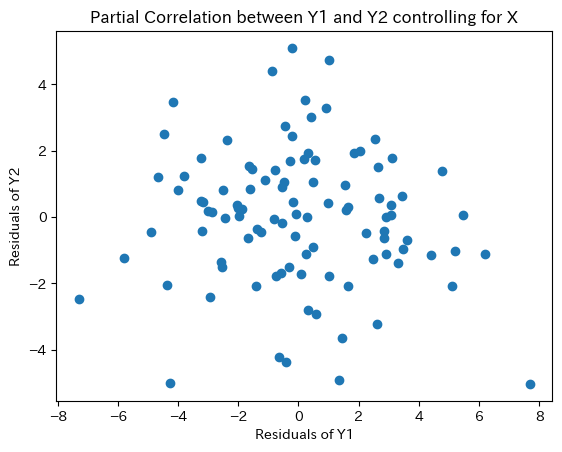

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


# 仮想データの生成（実際には実データを使用）
np.random.seed(0)
X = np.random.randn(100, 3) * 1.5 - 3
# Y1 = np.random.randn(100) * 3 + 4
# Y2 = np.random.randn(100) * 2 + 1
Y1 = -1.7 * X.dot([1.1, -0.7, 0.3]) + np.random.randn(100) * 3 + 4
Y2 = 0.23 * X.dot([-1.3, 0.2, 0.5]) + np.random.randn(100) * 2 + 1

# Zに基づいてXの線形回帰モデルを構築
model_Y1 = LinearRegression().fit(X, Y1)
# Xの予測値を計算し、残差を求める
predicted_Y1 = model_Y1.predict(X)
residuals_Y1 = Y1 - predicted_Y1

# Zに基づいてYの線形回帰モデルを構築
model_Y2 = LinearRegression().fit(X, Y2)
# Yの予測値を計算し、残差を求める
predicted_Y2 = model_Y2.predict(X)
residuals_Y2 = Y2 - predicted_Y2

# 残差を用いてXとYの関係を視覚化
plt.scatter(residuals_Y1, residuals_Y2)
plt.xlabel("Residuals of Y1")
plt.ylabel("Residuals of Y2")
plt.title("Partial Correlation between Y1 and Y2 controlling for X")
plt.show()

In [ ]:
np.corrcoef(residuals_Y1, residuals_Y2)

array([[ 1.       , -0.0990454],
       [-0.0990454,  1.       ]])

In [ ]:
import pandas as pd


df = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "X2": X[:, 2], "Y1": Y1, "Y2": Y2})
df.head(3)

,X0,X1,X2,Y1,Y2
0,-0.353921,-2.399764,-1.531893,-1.332201,-0.378042
1,0.361340,-0.198663,-4.465917,10.339895,-1.862554
2,-1.574867,-3.227036,-3.154828,4.359300,2.492963


In [ ]:
# Y1, Y2 | X
np.corrcoef(
    Q(X - X.mean(axis=0)).dot(Y1 - Y1.mean(axis=0)),
    Q(X - X.mean(axis=0)).dot(Y2 - Y2.mean(axis=0)),
)

array([[ 1.       , -0.0990454],
       [-0.0990454,  1.       ]])